# ER Pipeline - Pandas - Moritz Wassmer - 0467748

In [1]:
import pandas as pd

from data_prep import *
from blocking import *
from matching import *
from evaluation import *
from clustering import *
from helpers import *
from params import *
from pipelines import *

import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2) Entity Resolution Pipeline

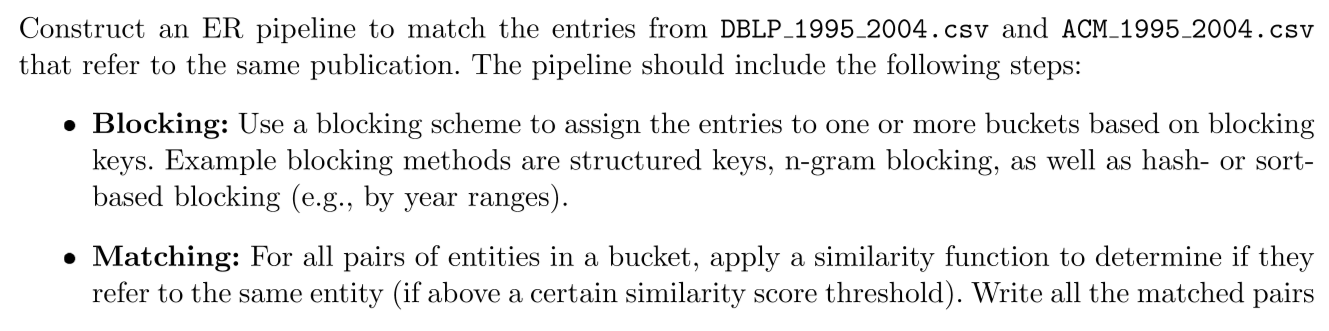
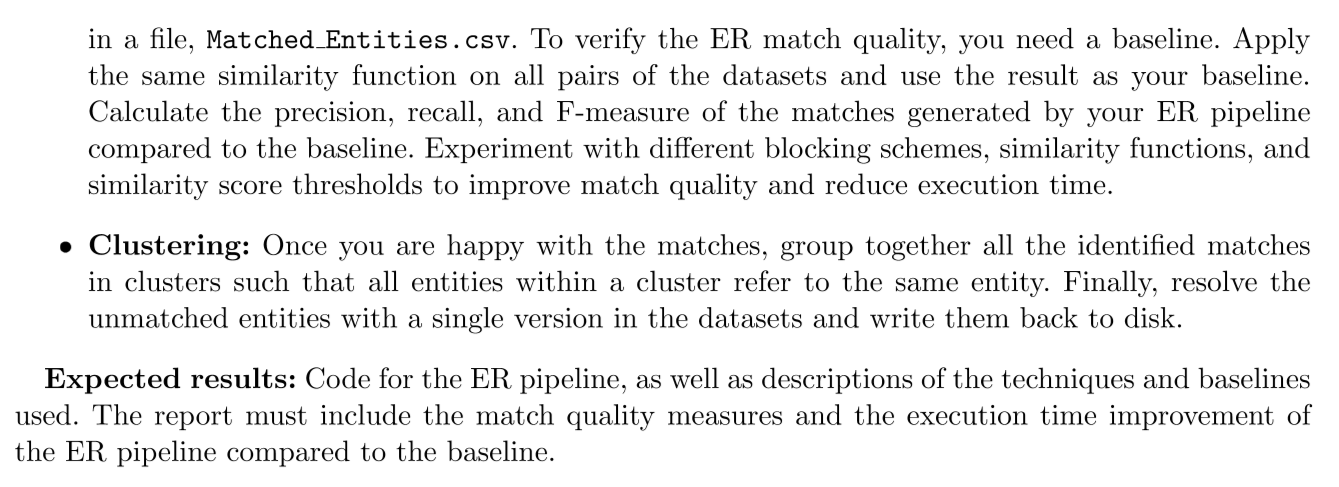

Load CSV from File

In [2]:
filtered_dblp_df = cast_df(pd.read_csv(OUT_DBLP_FILTERED))
filtered_acm_df = cast_df(pd.read_csv(OUT_ACM_FILTERED))

Example Data

In [ ]:
#filtered_dblp_df.head(50)

In [ ]:
#filtered_acm_df.head(50)

### How to choose blocking and Matchign Scheme
- I can capture performance and runtime of blocking schemes
- i can only measure runtime of matching schemes but not performance
- Baseline is computationaly expensive and depends on matching scheme

--> since the computation of the baseline only depends only on the matching strategy i fixate the matching scheme first. 

### Choice of Matching Scheme / Similarity Measure
- there is no clear right and wrong similarity measure without looking by hand at the matched results
- fixate on  one blocking scheme for comparison reasons - buckets_by_authors

--> make initial guess based on intuition - Fancy Similarity, optimize by looking at how many matched rows we get, look at a handful of matches, look at execution time

#### a) Exact Match
Baseline for # Matches and Execution time

In [3]:
start_time = time.time()
bucket_matched, bucket_unmatched = er_pipeline(exact_match, filtered_acm_df, filtered_dblp_df, bucket_function=buckets_by_author, threshold=1)
end_time = time.time()
er_time = round(end_time - start_time,2)

print(f"er_time: {er_time}")
print(f"no_matches: {len(bucket_matched)}")

100%|██████████| 2343/2343 [00:11<00:00, 196.51it/s]


er_time: 12.08
no_matches: 0


#### b) Fancy Similarity

In [4]:
# Prepare new columns from venue column
filtered_acm_df["isSigmod"] = contains_str(filtered_acm_df["Venue"], "sigmod")
filtered_dblp_df["isSigmod"] = contains_str(filtered_dblp_df["Venue"], "sigmod")
filtered_acm_df["isVLDB"] = contains_str(filtered_acm_df["Venue"], "vldb")
filtered_dblp_df["isVLDB"] = contains_str(filtered_dblp_df["Venue"], "vldb")

# Prepare new columns from authors column
filtered_acm_df["Authors_new"] = filtered_acm_df["Authors"].apply(custom_author)
filtered_dblp_df["Authors_new"] = filtered_dblp_df["Authors"].apply(custom_author)

In [5]:
start_time = time.time()
bucket_matched, bucket_unmatched = er_pipeline(fancy_similarity, filtered_acm_df, filtered_dblp_df, bucket_function=buckets_by_author, threshold=1)
end_time = time.time()
er_time = round(end_time - start_time,2)

print(f"er_time: {er_time}")
print(f"no_matches: {len(bucket_matched)}")

100%|██████████| 2343/2343 [00:13<00:00, 172.37it/s]

er_time: 13.72
no_matches: 1461


Get Dataframe

In [6]:
bucket_matched_df, bucket_unmatched_df = er_pipeline(fancy_similarity, filtered_acm_df, filtered_dblp_df, bucket_function=buckets_by_author, threshold=1, return_df = True)

100%|██████████| 2343/2343 [00:09<00:00, 240.96it/s]


Investigate matches by hand -> looks good

In [7]:
bucket_matched_df.head(10)

,Title_acm,Authors_acm,Year_acm,Venue_acm,Index_acm,bucket_acm,ToKeep_acm,isSigmod_acm,isVLDB_acm,Authors_new_acm,Title_dblp,Authors_dblp,Year_dblp,Venue_dblp,Index_dblp,bucket_dblp,ToKeep_dblp,isSigmod_dblp,isVLDB_dblp,Authors_new_dblp
0,broadcast disks: data management for asymmetri...,"swarup acharya, rafael alonso, michael frankli...",1995,sigmod '95 proceedings of the 1995 acm sigmod ...,539087d420f70186a0d5df26,"a, f, m, r, s, z",False,True,False,"s acharya, r alonso, m franklin, s zdonik",broadcast disks: data management for asymmetri...,"swarup acharya, rafael alonso, michael j. fran...",1995,sigmod conference,53e9b740b7602d97042da0da,"a, f, m, r, s, z",True,True,False,"s acharya, r alonso, m franklin, s zdonik"
1,phrase matching in xml,"sihem amer-yahia, mary fernández, divesh sriva...",2003,vldb '03 proceedings of the 29th international...,53909f8c20f70186a0e3fe32,"a, d, f, m, s, x, y",False,False,True,"s amer-yahia, m fernández, d srivastava, y xu",phrase matching in xml.,"sihem amer-yahia, mary f. fernández, divesh sr...",2003,vldb,53e99b36b7602d97023d297b,"a, d, f, m, s, x, y",True,False,True,"s amer-yahia, m fernández, d srivastava, y xu"
2,pix: exact and approximate phrase matching in xml,"sihem amer-yahia, mary fernández, divesh sriva...",2003,proceedings of the 2003 acm sigmod internation...,53908d6520f70186a0dd1a36,"a, d, f, m, s, x, y",False,True,False,"s amer-yahia, m fernández, d srivastava, y xu",pix: exact and approximate phrase matching in ...,"sihem amer-yahia, mary f. fernández, divesh sr...",2003,sigmod conference,53e9b03db7602d9703a9eb2f,"a, d, f, m, s, x, y",True,True,False,"s amer-yahia, m fernández, d srivastava, y xu"
3,technology challenges in a data warehouse,ramesh bhashyam,2004,vldb '04 proceedings of the thirtieth internat...,53909f8c20f70186a0e401f7,"b, r",False,False,True,r bhashyam,technology challenges in a data warehouse.,ramesh bhashyam,2004,vldb,53e9b344b7602d9703e193aa,"b, r",True,False,True,r bhashyam
4,"tpc-d—the challenges, issues and results",ramesh bhashyam,1996,acm sigmod record,539087dd20f70186a0d62b50,"b, r",False,True,False,r bhashyam,"tpc-d: the challenges, issues and results.",ramesh bhashyam,1996,vldb,53e9af81b7602d97039c4d92,"b, r",True,False,True,r bhashyam
5,"tpc-d: the challenges, issues and results",ramesh bhashyam,1996,vldb '96 proceedings of the 22th international...,53908a9620f70186a0da4e2a,"b, r",False,False,True,r bhashyam,"tpc-d: the challenges, issues and results.",ramesh bhashyam,1996,vldb,53e9af81b7602d97039c4d92,"b, r",True,False,True,r bhashyam
6,mapping data in peer-to-peer systems: semantic...,"anastasios kementsietsidis, marcelo arenas, re...",2003,proceedings of the 2003 acm sigmod internation...,53908d6520f70186a0dd1a10,"a, k, m, r",False,True,False,"m arenas, a kementsietsidis, r miller",mapping data in peer-to-peer systems: semantic...,"anastasios kementsietsidis, marcelo arenas, re...",2003,sigmod conference,53e9ae0bb7602d9703816f7c,"a, k, m, r",True,True,False,"m arenas, a kementsietsidis, r miller"
7,"spatial, temporal and spatio-temporal database...","john f. roddick, erik hoel, max j. egenhofer, ...",2004,acm sigmod record,5390975920f70186a0dfe2be,"b, d, e, h, j, m, p, r, s",False,True,False,"m egenhofer, e hoel, d papadias, j roddick, b ...","spatial, temporal and spatio-temporal database...","john f. roddick, max j. egenhofer, erik g. hoe...",2004,sigmod record,53e9bb15b7602d970475279c,"b, d, e, h, j, m, p, r, s",True,True,False,"m egenhofer, e hoel, d papadias, j roddick, b ..."
8,the samos active dbms prototype,"stella gatziu, andreas geppert, klaus r. dittrich",1995,sigmod '95 proceedings of the 1995 acm sigmod ...,539087d420f70186a0d5df72,"a, d, g, k, s",False,True,False,"k dittrich, s gatziu, a geppert",the samos active dbms prototype.,"stella gatziu, andreas geppert, klaus r. dittrich",1995,sigmod conference,53e9b5f4b7602d9704147ee5,"a, d, g, k, s",True,True,False,"k dittrich, s gatziu, a geppert"
9,supporting global user profiles thro

#### c) Another simple baseline with threshold

In [8]:
for threshold in [0.5,0.6,0.7,0.8,0.9]:
    start_time = time.time()
    bucket_matched, bucket_unmatched = er_pipeline(simple_similarity, filtered_acm_df, filtered_dblp_df, bucket_function=buckets_by_author, threshold=threshold)
    end_time = time.time()
    er_time = round(end_time - start_time,2)
    print(f"threshold: {threshold}")
    print(f"er_time: {er_time}")
    print(f"no_matches: {len(bucket_matched)}")

100%|██████████| 2343/2343 [00:09<00:00, 257.53it/s]


threshold: 0.5
er_time: 9.21
no_matches: 1956


100%|██████████| 2343/2343 [00:08<00:00, 286.87it/s]


threshold: 0.6
er_time: 8.26
no_matches: 1790


100%|██████████| 2343/2343 [00:07<00:00, 296.34it/s]


threshold: 0.7
er_time: 8.0
no_matches: 1621


100%|██████████| 2343/2343 [00:07<00:00, 297.93it/s]


threshold: 0.8
er_time: 7.96
no_matches: 438


100%|██████████| 2343/2343 [00:09<00:00, 252.60it/s]

threshold: 0.9
er_time: 9.37
no_matches: 346


In [9]:
bucket_matched_df, bucket_unmatched_df = er_pipeline(simple_similarity, filtered_acm_df, filtered_dblp_df, bucket_function=buckets_by_author, threshold=0.7, return_df=True)

100%|██████████| 2343/2343 [00:10<00:00, 215.31it/s]


In [ ]:
#bucket_matched_df.head(10)

### Choice of Blocking Scheme
I fixate the matching similarity measure - fancy similarity for benchmarking 

#### Baseline - no blocking

Option to write resutls to csv

In [ ]:
"""bucket_matched_df, bucket_unmatched_df = er_pipeline(fancy_similarity, filtered_acm_df, filtered_dblp_df, return_df=True)
unbucket_matched_df, unbucket_unmatched_df  = baseline_pipeline(fancy_similarity, filtered_acm_df, filtered_dblp_df, return_df=True)
bucket_matched_df.to_csv(OUT_MATCHED, index=False)
unbucket_matched_df.to_csv(OUT_MATCHED_BASELINE, index=False)"""

Reload Baseline results from csv

In [10]:
unbucket_matched_df = pd.read_csv(OUT_MATCHED_BASELINE)
#bucket_matched_df = pd.read_csv(OUT_MATCHED)
unbucket_matched = df_to_tuples(unbucket_matched_df[["Index_acm", "Index_dblp"]])
#bucket_matched = df_to_tuples(bucket_matched_df[["Index_acm", "Index_dblp"]])

#### a) Bucketization by year

In [11]:
start_time = time.time()
bucket_matched, bucket_unmatched = er_pipeline(fancy_similarity, filtered_acm_df, filtered_dblp_df, bucket_function=bucket_by_year)
end_time = time.time()
er_time = round(end_time - start_time,2)

100%|██████████| 10/10 [04:36<00:00, 27.66s/it]


In [12]:
evaluate(set(bucket_matched), set(unbucket_matched))

True Positives (TP): 1469
False Positives (FP): 0
False Negatives (FN): 0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


#### b) Bucketization by year + venue

In [13]:
start_time = time.time()
bucket_matched, bucket_unmatched = er_pipeline(fancy_similarity, filtered_acm_df, filtered_dblp_df, bucket_function=bucket_by_year_venue)
end_time = time.time()
er_time = round(end_time - start_time,2)

100%|██████████| 20/20 [02:11<00:00,  6.60s/it]


In [14]:
evaluate(set(bucket_matched), set(unbucket_matched))

True Positives (TP): 1468
False Positives (FP): 1
False Negatives (FN): 0
Precision: 0.9993192648059904
Recall: 1.0
F1-score: 0.9996595165134491


#### c) Bucketization by author

In [15]:
start_time = time.time()
bucket_matched, bucket_unmatched = er_pipeline(fancy_similarity, filtered_acm_df, filtered_dblp_df, bucket_function=buckets_by_author)
end_time = time.time()
er_time = round(end_time - start_time,2)

100%|██████████| 2343/2343 [00:09<00:00, 241.06it/s]


In [16]:
evaluate(set(bucket_matched), set(unbucket_matched))

True Positives (TP): 1455
False Positives (FP): 14
False Negatives (FN): 0
Precision: 0.9904697072838666
Recall: 1.0
F1-score: 0.9952120383036936


# 3) Data-Parallel Entity Resolution Pipeline

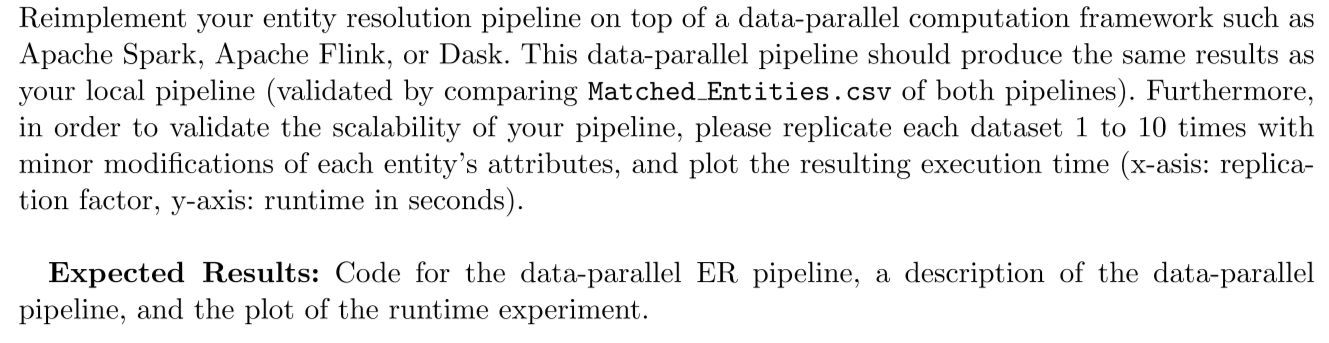

Initialize spark

In [17]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable #"jupyter"
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"



from pyspark import SparkContext
from pyspark.sql import SparkSession

sc = SparkContext.getOrCreate() 
spark_builder = SparkSession.builder.appName("ER") \
    .config("spark.ui.reverseProxy", "true") \
    .config("spark.ui.reverseProxyUrl", "http://your-spark-ui-url") \
    .config("spark.executor.memory", "8g")\
    .config("spark.driver.memory", "8g")\
    .config("spark.executor.instances", "2")\
    .config("spark.executor.cores", "4")\
    .config("spark.default.parallelism", "8")\
    .config("spark.dynamicAllocation.enabled", "true")\
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.master", "local[4]")

# Create SparkSession
spark = spark_builder.getOrCreate()

Reload parsed data

In [18]:
"""filtered_dblp_df = cast_df(pd.read_csv(OUT_DBLP_FILTERED))
filtered_acm_df = cast_df(pd.read_csv(OUT_ACM_FILTERED))"""

'filtered_dblp_df = cast_df(pd.read_csv(OUT_DBLP_FILTERED))\nfiltered_acm_df = cast_df(pd.read_csv(OUT_ACM_FILTERED))'

#### Original ER-Pipeline

Run ER Pipeline

In [19]:
dblp_spark_df = spark.createDataFrame(filtered_dblp_df)
acm_spark_df = spark.createDataFrame(filtered_acm_df)

spark.udf.register("levenstein", levenshtein)
simple_similarity_expr = f"(bucket_acm == bucket_dblp) AND ((CAST(Year_acm == Year_dblp AS int) + levenstein(Title_acm, Title_dblp) + levenstein(Venue_acm, Venue_dblp))/3 > '{THRESHOLD}')"
fancy_similarity_expr = f"(bucket_acm == bucket_dblp) AND Year_acm == Year_dblp AND levenstein(Authors_new_acm, Authors_new_dblp) > 0.9 AND levenstein(Title_acm, Title_dblp) > 0.9 AND (isSigmod_acm AND isSigmod_dblp OR isVLDB_acm AND isVLDB_dblp)"
#bucket_matched_spark, bucket_unmatched_spark = spark_pipeline(total_simiarity_expr, acm_spark_df, dblp_spark_df, threshold=THRESHOLD,bucket_function=buckets_by_author_spark)

Write to dsik option

In [20]:
bucket_matched_spark_df = spark_pipeline(fancy_similarity_expr, acm_spark_df, dblp_spark_df, threshold=THRESHOLD,bucket_function=buckets_by_author_spark,return_df=True)
bucket_matched_spark_df.toPandas().to_csv(OUT_MATCHED_SPARK, index=False)

matching time:20.65
clustering time:0.0
resolving time:10.78


Evaluation

reload baseline results from csv

In [21]:
# Reload baseline from csv
unbucket_matched_df = pd.read_csv(OUT_MATCHED_BASELINE)
bucket_matched_spark_df = pd.read_csv(OUT_MATCHED_SPARK)
bucket_matched_df = pd.read_csv(OUT_MATCHED)
bucket_matched = df_to_tuples(bucket_matched_df[["Index_acm", "Index_dblp"]])
unbucket_matched = df_to_tuples(unbucket_matched_df[["Index_acm", "Index_dblp"]])
bucket_matched_spark = df_to_tuples(bucket_matched_spark_df[["Index_acm", "Index_dblp"]])

run evaluation by comparison to baseline

In [22]:
evaluate(set(bucket_matched_spark), set(unbucket_matched))

True Positives (TP): 1454
False Positives (FP): 15
False Negatives (FN): 0
Precision: 0.989788972089857
Recall: 1.0
F1-score: 0.9948682860075265


check if csv is same as pandas matching

In [23]:
len(bucket_matched)

1461

In [24]:
len(bucket_matched_spark)

1458

In [25]:
set(bucket_matched_spark).symmetric_difference(bucket_matched)

{('539087dd20f70186a0d62b50', '53e9af81b7602d97039c4d92')}

#### Replication Experiment

In [26]:
times = []

for i in range(1,11): # TODO

    print(f"replication factor: {i}")
    
    dblp_spark_df = spark.createDataFrame(modify_and_concat(filtered_dblp_df, i))
    acm_spark_df = spark.createDataFrame(modify_and_concat(filtered_acm_df, i))

    start_time = time.time()
    # run pipeline
    bucket_matched_spark = spark_pipeline(
        fancy_similarity_expr, 
        acm_spark_df, 
        dblp_spark_df, 
        threshold=THRESHOLD,
        bucket_function=buckets_by_author_spark,
        #return_df=True
    )
    end_time = time.time()
    er_time = round(end_time - start_time,2)

    print(f"total time: {er_time}\n")

    times += [er_time]

replication factor: 1
matching time:19.14
clustering time:0.0
resolving time:12.01
total time: 31.32

replication factor: 2
matching time:17.23
clustering time:0.01
resolving time:12.26
total time: 29.72

replication factor: 3
matching time:17.95
clustering time:0.01
resolving time:11.53
total time: 29.64

replication factor: 4
matching time:18.7
clustering time:0.02
resolving time:10.72
total time: 29.58

replication factor: 5
matching time:18.56
clustering time:0.02
resolving time:10.08
total time: 28.82

replication factor: 6
matching time:18.92
clustering time:0.06
resolving time:11.51
total time: 30.63

replication factor: 7
matching time:19.0
clustering time:0.08
resolving time:12.54
total time: 31.77

replication factor: 8
matching time:17.57
clustering time:0.06
resolving time:10.53
total time: 28.32

replication factor: 9
matching time:19.33
clustering time:0.11
resolving time:11.27
total time: 30.87

replication factor: 10
matching time:18.68
clustering time:0.11
resolving ti

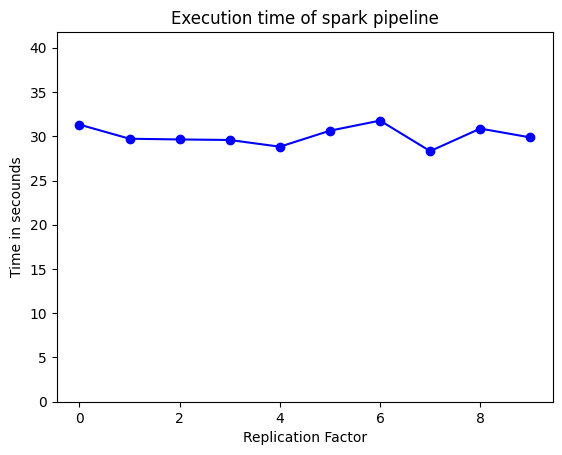

In [27]:
import matplotlib.pyplot as plt

# Plotting the time values against their respective indices
plt.plot(range(len(times)), times, marker='o', linestyle='-', color='b', label='Time Values')

# Adding labels and title
plt.xlabel('Replication Factor')
plt.ylabel('Time in secounds')
plt.title('Execution time of spark pipeline')
#plt.legend()
plt.ylim(0, max(times)+10)

# Show the plot
plt.show()